# Visualizing Metis data

In this notebook, we present general tools of `matplotlib` and `sunpy` for performing basic operation with Metis visible light (VL) and ultraviolet (UV) images.

## Visualzing VL and UV data

Importing necessary packages

In [1]:
%matplotlib inline
#%matplotlib notebook

from os.path import basename
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u

Configuring color maps

In [2]:
Metis_VL_CMAP = cm.get_cmap('afmhot').copy()
Metis_VL_CMAP.set_bad(color='tab:gray')  # np.nan values are in gray

Metis_UV_CMAP = cm.get_cmap('Blues_r').copy()
Metis_UV_CMAP.set_bad(color='tab:gray')  # np.nan values are in gray

Reading Metis VL polarized brightness (pB) image

In [3]:
fname_metis_pb = './data/data_for_nb1_vis/solo_L2_metis-vl-pb_20211225T001701_V01.fits'
hdu0_pb = fits.open(fname_metis_pb)[0]
wcs_pb = WCS(hdu0_pb.header)

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59573.011819 from DATE-BEG.
Set MJD-AVG to 59573.015346 from DATE-AVG.
Set MJD-END to 59573.018873 from DATE-END'. [astropy.wcs.wcs]


Plotting Metis pB image

Text(0.5, 1.0, 'Metis pB image\nsolo_L2_metis-vl-pb_20211225T001701_V01.fits')

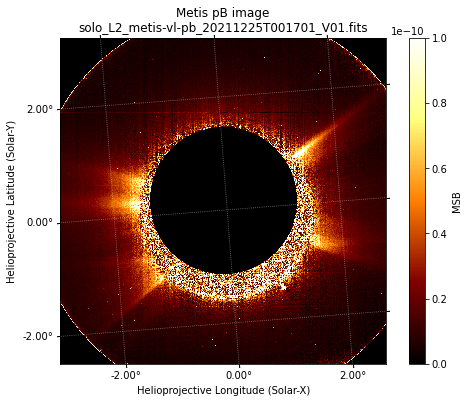

In [4]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection=wcs_pb))

img_pb = ax1.imshow(hdu0_pb.data, origin='lower', vmax=1e-10, cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb = plt.colorbar(img_pb, ax=ax1, label='MSB')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Metis pB image\n' + basename(fname_metis_pb))

Cutting inner and outer parts of field of view

In [5]:
if hdu0_pb.header['CDELT1'] != hdu0_pb.header['CDELT2']:
    raise ValueError("Error. hdu0_pb.header['CDELT1'] != hdu0_pb.header['CDELT2'].")
fov1 = hdu0_pb.header['INN_FOV']*3600/hdu0_pb.header['CDELT1']  # pix
fov2 = hdu0_pb.header['OUT_FOV']*3600/hdu0_pb.header['CDELT2']  # pix 
x = np.arange(0, hdu0_pb.header['NAXIS1'], 1)
y = np.arange(0, hdu0_pb.header['NAXIS2'], 1)
xx, yy = np.meshgrid(x, y, sparse=True)
dist_suncen = np.sqrt((xx-hdu0_pb.header['SUN_XCEN'])**2 + (yy-hdu0_pb.header['SUN_YCEN'])**2)
dist_iocen = np.sqrt((xx-hdu0_pb.header['IO_XCEN'])**2 + (yy-hdu0_pb.header['IO_YCEN'])**2)
hdu0_pb.data[dist_iocen < fov1] = np.nan
hdu0_pb.data[dist_suncen > fov2] = np.nan

Text(0.5, 1.0, 'Metis pB image\nsolo_L2_metis-vl-pb_20211225T001701_V01.fits')

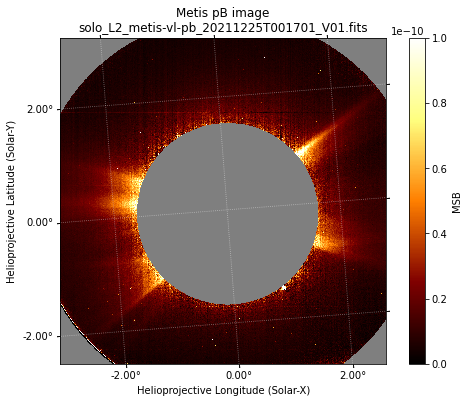

In [6]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection=wcs_pb))

img_pb = ax1.imshow(hdu0_pb.data, origin='lower', vmax=1e-10, cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb = plt.colorbar(img_pb, ax=ax1, label='MSB')

lon, lat = ax1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
ax1.set_xlabel('Helioprojective Longitude (Solar-X)')
ax1.set_ylabel('Helioprojective Latitude (Solar-Y)')
ax1.set_title('Metis pB image\n' + basename(fname_metis_pb))

Defining auxiliary functions

In [7]:
def setup_metis_ax(ax, fname, cbar):
    lon, lat = ax.coords
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    ax.coords.grid(True, color = 'white', ls = 'dotted', alpha = 0.5)
    ax.set_xlabel('Helioprojective Longitude (Solar-X)')
    ax.set_ylabel('Helioprojective Latitude (Solar-Y)')
    ax_title = basename(fname).replace('.fits', '')
    ax.set_title(ax_title)
    
def cut_metis_fov(hdu, rotate=False):
    if hdu.header['CDELT1'] != hdu.header['CDELT2']:
        raise ValueError("Error. CDELT1 != CDELT2 for {fname}".format(fname=hdu.header['FILENAME']))
    fov1 = hdu.header['INN_FOV']*3600/hdu.header['CDELT1']  # pix
    fov2 = hdu.header['OUT_FOV']*3600/hdu.header['CDELT2']  # pix 
    x = np.arange(0, hdu.header['NAXIS1'], 1)
    y = np.arange(0, hdu.header['NAXIS2'], 1)
    xx, yy = np.meshgrid(x, y, sparse=True)
    dist_suncen = np.sqrt((xx-hdu.header['SUN_XCEN'])**2 + (yy-hdu.header['SUN_YCEN'])**2)
    dist_iocen = np.sqrt((xx-hdu.header['IO_XCEN'])**2 + (yy-hdu.header['IO_YCEN'])**2)
    hdu.data[dist_iocen < fov1] = np.nan
    hdu.data[dist_suncen > fov2] = np.nan

Reading and preparing the total brightness (tB) and UV Metis images

In [8]:
fname_metis_tb = './data/data_for_nb1_vis/solo_L2_metis-vl-tb_20211225T001701_V01.fits'
hdu0_tb = fits.open(fname_metis_tb)[0]
wcs_tb = WCS(hdu0_tb.header)
cut_metis_fov(hdu0_tb)

fname_metis_uv = './data/data_for_nb1_vis/solo_L2_metis-uv-image_20211225T001700_V01.fits'
hdu0_uv = fits.open(fname_metis_uv)[0]
wcs_uv = WCS(hdu0_uv.header)
cut_metis_fov(hdu0_uv)

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59573.011819 from DATE-BEG.
Set MJD-AVG to 59573.015346 from DATE-AVG.
Set MJD-END to 59573.018873 from DATE-END'. [astropy.wcs.wcs]
keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-BEG to 59573.011813 from DATE-BEG.
Set MJD-AVG to 59573.012160 from DATE-AVG.
Set MJD-END to 59573.012507 from DATE-END'. [astropy.wcs.wcs]


Plotting quasi-simultaneous tB, pB and UV Metis images

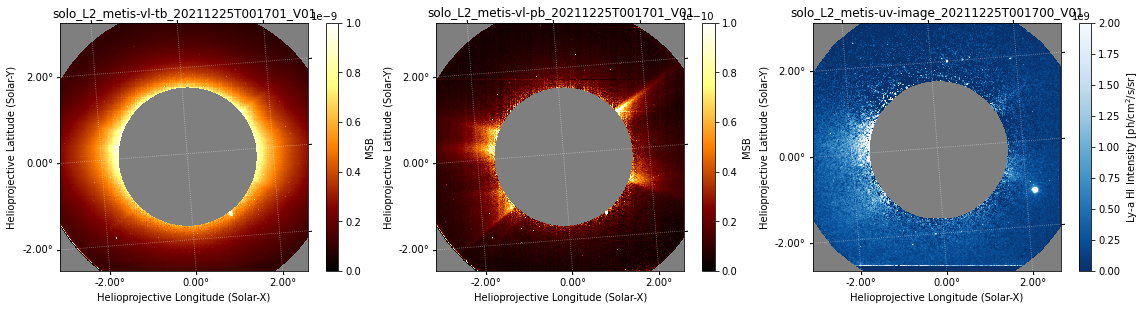

In [9]:
fig2 = plt.figure(figsize=(16,4))
ax21 = fig2.add_subplot(1, 3, 1, projection=wcs_tb)
ax22 = fig2.add_subplot(1, 3, 2, projection=wcs_pb)
ax23 = fig2.add_subplot(1, 3, 3, projection=wcs_uv)

img_tb = ax21.imshow(hdu0_tb.data, origin='lower', vmin=0.0, vmax=1e-9, 
                      cmap=Metis_VL_CMAP, interpolation='none')
cbar_tb = plt.colorbar(img_tb, ax=ax21, label='MSB')

img_pb = ax22.imshow(hdu0_pb.data, origin='lower', vmin=0.0, vmax=1e-10, 
                      cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb = plt.colorbar(img_pb, ax=ax22, label='MSB')

img_uv = ax23.imshow(hdu0_uv.data, origin='lower', vmin=0.0, vmax=2e9, 
                      cmap=Metis_UV_CMAP, interpolation='none')
cbar_uv = plt.colorbar(img_uv, ax=ax23, label=r'Ly-a HI Intensity [$\rm{ph/cm^2/s/sr}$]')

setup_metis_ax(ax21, fname_metis_tb, cbar_tb)
setup_metis_ax(ax22, fname_metis_pb, cbar_pb)
setup_metis_ax(ax23, fname_metis_uv, cbar_uv)

fig2.tight_layout()

## Quality and error matrices

Metis L2 fits files contain two additional extensions with Quality and Error Matrices related to the main image.

Quality matrix has the following values:
- NaN, for all saturated pixels;
- NaN, for all pixels having a value well below the average detector bias level;
- 1 for all good pixels, i.e., within the detector linearity range;
- 0 for all remaining pixels.

Error matrix contains only zeros in the first Metis data release.

Let's open pB fits file and print the names of its extensions

In [10]:
fname_metis_pb2 = './data/data_for_nb1_vis/solo_L2_metis-vl-pb_20211225T001701_V01.fits'
hdu0_pb2, hdu1_pb2, hdu2_pb2  = fits.open(fname_metis_pb2)
print('hdu0 name:', hdu0_pb2.name)
print('hdu1 name:', hdu1_pb2.name)
print('hdu2 name:', hdu2_pb2.name)
print('---')
print('All hdu2 pixels == 0.0:', np.all(hdu2_pb2.data) == 0.0)

hdu0 name: PRIMARY
hdu1 name: Quality matrix
hdu2 name: Error matrix
---
All hdu2 pixels == 0.0: True


This is how PRIMARY and Quality matrix HDUs look like

Text(0.5, 1.0, 'Quality matrix HDU data')

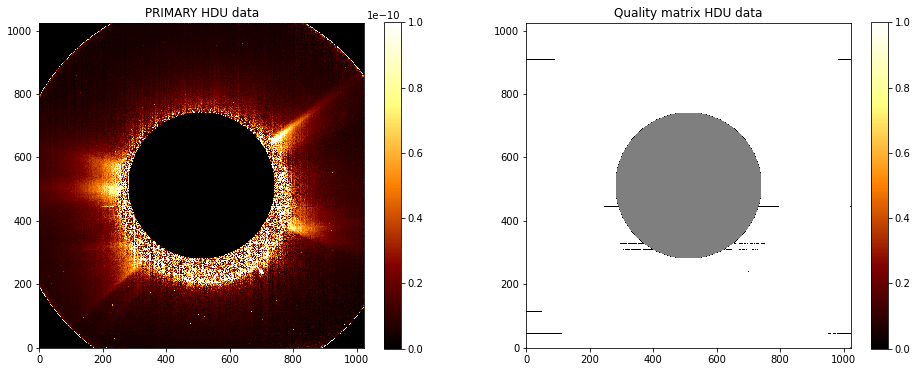

In [11]:
fig3, axs3 = plt.subplots(1, 2, figsize=(16,6))

img_pb2 = axs3[0].imshow(hdu0_pb2.data, origin='lower', vmin=0.0, vmax=1e-10, 
                         cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb2 = plt.colorbar(img_pb2, ax=axs3[0])
axs3[0].set_title(hdu0_pb2.name + ' HDU data')

img_pb2_qm = axs3[1].imshow(hdu1_pb2.data, origin='lower', 
                            cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb2_qm = plt.colorbar(img_pb2_qm, ax=axs3[1])
axs3[1].set_title(hdu1_pb2.name + ' HDU data')

Masking 'bad' pixels in the pB image and re-plotting it

Text(0.5, 1.0, 'Quality matrix HDU data')

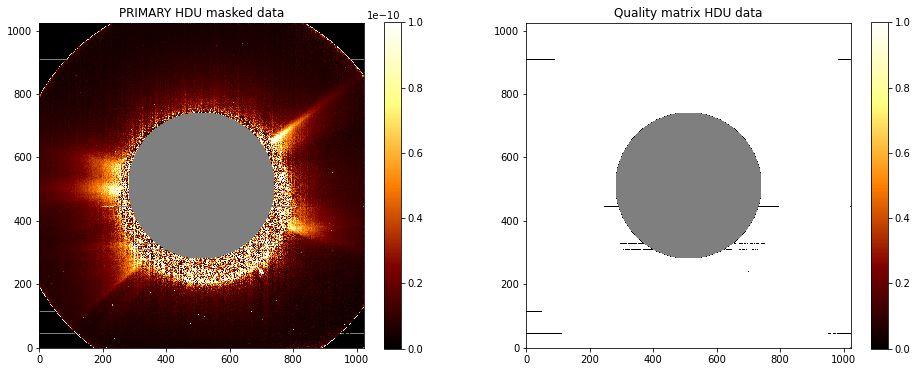

In [12]:
hdu0_pb2.data[hdu1_pb2.data != 1] = np.nan

fig3, axs3 = plt.subplots(1, 2, figsize=(16,6))

img_pb2 = axs3[0].imshow(hdu0_pb2.data, origin='lower', vmin=0.0, vmax=1e-10, 
                         cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb2 = plt.colorbar(img_pb2, ax=axs3[0])
axs3[0].set_title(hdu0_pb2.name + ' HDU masked data')

img_pb2_qm = axs3[1].imshow(hdu1_pb2.data, origin='lower', 
                            cmap=Metis_VL_CMAP, interpolation='none')
cbar_pb2_qm = plt.colorbar(img_pb2_qm, ax=axs3[1])
axs3[1].set_title(hdu1_pb2.name + ' HDU data')

## Visualzing Metis data with SunPy (https://sunpy.org)
(Following examples require SunPy 4.0.3 or higher)

Importing sunpy map

In [13]:
import sunpy.map

Reading Metis pB image

In [14]:
fname_metis_pb3 = './data/data_for_nb1_vis/solo_L2_metis-vl-pb_20211225T001701_V01.fits'
hdu0_pb3 = fits.open(fname_metis_pb3)[0]
cut_metis_fov(hdu0_pb3)

Defining SunPy map

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

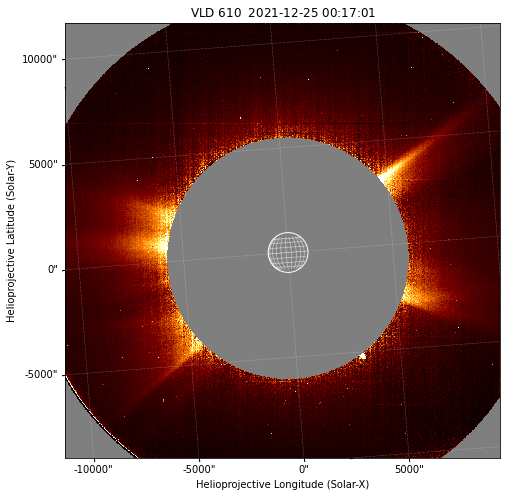

In [15]:
# defining 'RSUN_OBS' keyword so that sunpy.map.Map correctly reads solar radius
hdu0_pb3.header['RSUN_OBS'] = hdu0_pb3.header['RSUN_ARC']
map_metis_pb3 = sunpy.map.Map(hdu0_pb3.data, hdu0_pb3.header)

plt.figure(figsize=(8,8))
map_metis_pb3.plot(vmin=0.0, vmax=1e-10, cmap=Metis_VL_CMAP)
map_metis_pb3.draw_limb()
map_metis_pb3.draw_grid()

And rotating it (for more details see https://docs.sunpy.org/en/stable/generated/gallery/map/map_rotation.html)

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

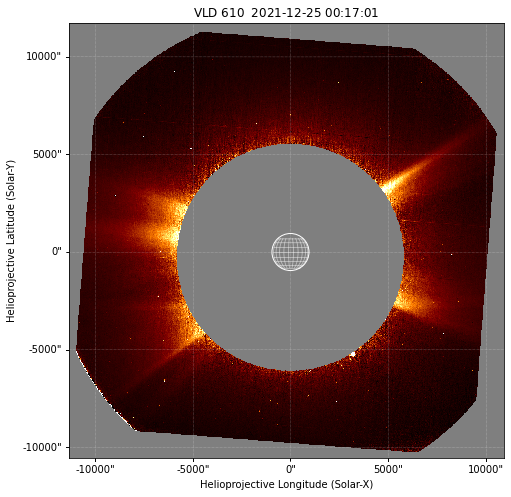

In [16]:
map_metis_pb3_rotated = map_metis_pb3.rotate()

plt.figure(figsize=(8,8))
map_metis_pb3_rotated.plot(vmin=0.0, vmax=1e-10, cmap=Metis_VL_CMAP)
map_metis_pb3_rotated.draw_limb()
map_metis_pb3_rotated.draw_grid()

### Image enhancement filters

Applying MGN filter (for more details see: https://docs.sunpy.org/projects/sunkit-image/en/latest/generated/gallery/multiscale_gaussian_normalization.html)

In [17]:
import sunkit_image.enhance as enhance

In [18]:
hdu0_pb3_mgn_data = np.copy(hdu0_pb3.data)
hdu0_pb3_mgn_data[np.isnan(hdu0_pb3_mgn_data)] = 0.0
hdu0_pb3_mgn_data = enhance.mgn(hdu0_pb3_mgn_data, k=0.2)

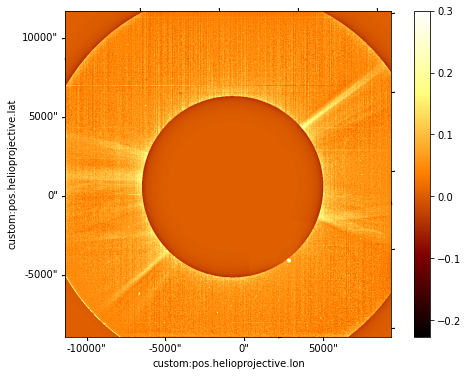

In [19]:
fig4, ax4 = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection=map_metis_pb3))
img_pb3_mgn = ax4.imshow(hdu0_pb3_mgn_data, origin='lower', vmax=0.3, cmap=Metis_VL_CMAP)
cbar_pb3_mgn = plt.colorbar(img_pb3_mgn, ax=ax4)

Applying NRGF filter (for more details see: https://docs.sunpy.org/projects/sunkit-image/en/latest/generated/gallery/radial_gradient_filters.html)

In [20]:
import sunkit_image.radial as radial
from sunkit_image.utils import equally_spaced_bins

In [21]:
fov1_rsun = hdu0_pb3.header['INN_FOV']*3600/hdu0_pb3.header['RSUN_ARC']  # rsun
fov2_rsun = hdu0_pb3.header['OUT_FOV']*3600/hdu0_pb3.header['RSUN_ARC']  # rsun
radial_bin_edges = equally_spaced_bins(fov1_rsun, fov2_rsun)
radial_bin_edges *= u.R_sun
map_metis_pb3_nrgf = radial.nrgf(map_metis_pb3, radial_bin_edges, width_function=np.nanstd)

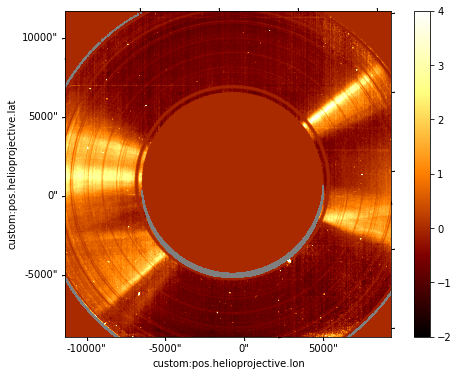

In [22]:
fig5, ax5 = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection=map_metis_pb3))
img_pb3_mgn = ax5.imshow(map_metis_pb3_nrgf.data, origin='lower', vmin=-2.0, vmax=4.0, 
                         cmap=Metis_VL_CMAP)
cbar_pb3_mgn = plt.colorbar(img_pb3_mgn, ax=ax5)

### Identification of stars and planets
(for more details see: https://docs.sunpy.org/en/stable/generated/gallery/units_and_coordinates/STEREO_SECCHI_starfield.html#sphx-glr-generated-gallery-units-and-coordinates-stereo-secchi-starfield-py)

Importing necessary packages

In [23]:
from astroquery.simbad import Simbad

from astropy.coordinates import Distance, SkyCoord
from astropy.time import Time

from sunpy.coordinates import get_body_heliographic_stonyhurst

Defining pB map

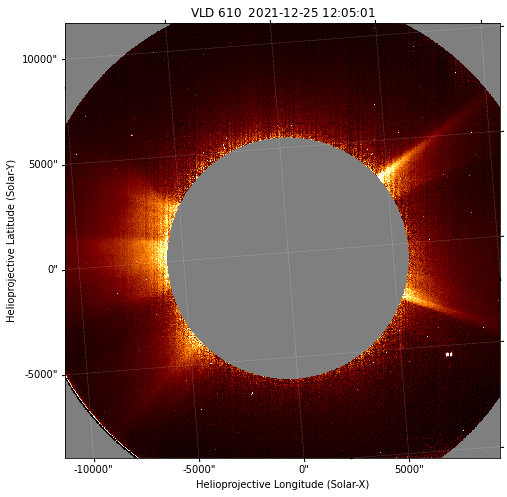

In [24]:
fname_metis_pb4 = './data/data_for_nb1_vis/solo_L2_metis-vl-pb_20211225T120501_V01.fits'
hdu0_pb4 = fits.open(fname_metis_pb4)[0]
hdu0_pb4.header['RSUN_OBS'] = hdu0_pb4.header['RSUN_ARC']
cut_metis_fov(hdu0_pb4)

map_metis_pb4 = sunpy.map.Map(hdu0_pb4.data, hdu0_pb4.header)

plt.figure(figsize=(8,8))
map_metis_pb4.plot(vmin=0.0, vmax=1e-10, cmap=Metis_VL_CMAP)

Definig vectors that point from the Sun to Metis and vice-versa

In [25]:
sun_to_metis = map_metis_pb4.observer_coordinate.transform_to('hcrs')
metis_to_sun = SkyCoord(-sun_to_metis.spherical, obstime=sun_to_metis.obstime, frame='hcrs')

This auxiliary function performs a search of the field stars in Simbad

In [26]:
def simbad_search(ra, dec, inn_fov, out_fov, max_mag=6):
    
    # ref https://astroquery.readthedocs.io/en/latest/simbad/simbad.html    
    cs = Simbad()  # custom query fields
    cs.add_votable_fields('ra(d;A;ICRS;J2000;2000)', 'dec(d;D;ICRS;J2000;2000)') # ICRS decimal coords
    cs.add_votable_fields('flux(V)') # Visible flux
    cs.add_votable_fields('id(HD)')
    cs.add_votable_fields('pmra')
    cs.add_votable_fields('pmdec')
    cs.add_votable_fields('plx')
    cs.add_votable_fields('rv_value')
    #cs.remove_votable_fields('coordinates')
    # cs.get_votable_fields()
    # Simbad.get_field_description('id')
    
    if dec >=0:
        dec_sign = '+'
    else:
        dec_sign = ''
    
    # query SIMBAD database
    res = cs.query_criteria(f'region(circle, ICRS, {ra} {dec_sign}{dec}, {out_fov}d) & Vmag < {max_mag}')
    
    # remove stars in the inner Metis FOV
    cen_coords = SkyCoord(ra*u.degree, dec*u.degree, frame='icrs')
    sep = cen_coords.separation(
        SkyCoord(
            ra=res['RA_d_A_ICRS_J2000_2000'], 
            dec=res['DEC_d_D_ICRS_J2000_2000'], 
            frame='icrs'
        )
    )
    res = res[sep > inn_fov*u.degree]

    return res

Searching for stars of Vmag < 7 in the circle < 5.1 deg

In [27]:
simbad_query = simbad_search(
    metis_to_sun.transform_to('icrs').ra.value,
    metis_to_sun.transform_to('icrs').dec.value,
    0.0, # hdu0_pb4.header['INN_FOV'],
    1.5*hdu0_pb4.header['OUT_FOV'], # 3.0,
    max_mag=7
)
print(len(simbad_query), 'stars found')

30 stars found


In [28]:
print(simbad_query.info)

<Table length=30>
          name           dtype    unit    format                            description                            n_bad
----------------------- ------- -------- -------- ---------------------------------------------------------------- -----
                MAIN_ID  object                                                      Main identifier for an object     0
                     RA   str13  "h:m:s"                                                           Right ascension     0
                    DEC   str13  "d:m:s"                                                               Declination     0
                RA_PREC   int16                                                          Right ascension precision     0
               DEC_PREC   int16                                                              Declination precision     0
           COO_ERR_MAJA float32      mas  {:6.3f}                                      Coordinate error major axis     0
           COO

In [29]:
print(simbad_query)

  MAIN_ID          RA           DEC      RA_PREC ...   PMDEC   PLX_VALUE RV_VALUE SCRIPT_NUMBER_ID
                "h:m:s"       "d:m:s"            ...  mas / yr    mas     km / s                  
------------ ------------- ------------- ------- ... --------- --------- -------- ----------------
   *  43 Oph 17 23 21.5908 -28 08 34.200      14 ...   -30.511     6.157  -11.950                0
   HD 159881 17 38 11.9881 -28 02 48.350      14 ...   -16.174     3.240   -6.000                0
   HD 155379 17 12 13.6199 -25 15 18.511      14 ...   -48.374     6.846   -3.400                0
   *  29 Sco 17 14 14.2497 -26 59 03.909      14 ...   -67.643    11.474    5.260                0
 *  36 Oph A 17 15 20.7836 -26 36 06.117      14 ... -1149.158   168.003    0.440                0
V* V2215 Oph 17 16 13.3624 -26 32 46.136      14 ... -1124.332   167.962   -0.090                0
 *  36 Oph B 17 15 20.9838 -26 36 10.173      14 ... -1141.168   168.130    0.100                0
   HD 1578

Loading all stars into a `SkyCoord` array

In [30]:
tbl_crds = SkyCoord(ra=simbad_query['RA_d_A_ICRS_J2000_2000'],
                    dec=simbad_query['DEC_d_D_ICRS_J2000_2000'],
                    distance=Distance(parallax=u.Quantity(simbad_query['PLX_VALUE'])),
                    pm_ra_cosdec=simbad_query['PMRA'],
                    pm_dec=simbad_query['PMDEC'],
                    radial_velocity=simbad_query['RV_VALUE'],
                    frame='icrs',
                    obstime=Time([2000]*len(simbad_query['RA_d_A_ICRS_J2000_2000']), format='jyear')
                   )
tbl_crds = tbl_crds.apply_space_motion(new_obstime=map_metis_pb4.date)

/home/idatauser/burtovoi/battlestar/My_SolarSoft/envs/sunpyenv/lib/python3.8/site-packages/erfa/core.py:4991: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/home/idatauser/burtovoi/battlestar/My_SolarSoft/envs/sunpyenv/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 2 of "solution didn't converge (Note 8)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In addition, we calculate the location of Venus

In [31]:
venus = get_body_heliographic_stonyhurst('venus', map_metis_pb4.date, observer=map_metis_pb4.observer_coordinate)

INFO: Apparent body location accounts for 144.51 seconds of light travel time [sunpy.coordinates.ephemeris]


Marking stars/planet position at the Metis image

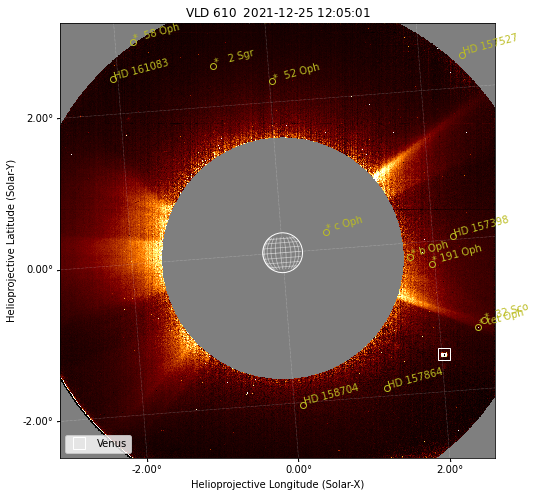

In [32]:
fig6 = plt.figure(figsize=(8,8))
ax6 = fig6.add_subplot(projection=map_metis_pb4)

lon, lat = ax6.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

map_metis_pb4.plot(axes=ax6, vmin=0.0, vmax=1e-10, cmap=Metis_VL_CMAP)
map_metis_pb4.draw_limb(axes=ax6)
map_metis_pb4.draw_grid(axes=ax6)

# Plot the position of Venus
ax6.plot_coord(venus, 's', color='white', fillstyle='none', markersize=12, label='Venus')

# Plot all of the stars
ax6.plot_coord(tbl_crds, 'o', color='tab:olive', fillstyle='none')
for star_name, star_coords in zip(simbad_query['MAIN_ID'].tolist(), tbl_crds):
    star_coords_pix = star_coords.to_pixel(map_metis_pb4.wcs)
    if (0 <= star_coords_pix[0] <= map_metis_pb4.data.shape[0])  \
            and (0 <= star_coords_pix[1] <= map_metis_pb4.data.shape[1]):
        ax6.text(star_coords_pix[0], star_coords_pix[1], star_name,
                rotation=15, color='tab:olive')
ax6.legend()

ax6.set_xlim(0, map_metis_pb4.data.shape[0])
ax6.set_ylim(0, map_metis_pb4.data.shape[1])

plt.show()